<a href="https://colab.research.google.com/github/purushu321/oralcancer/blob/main/mouth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
import tensorflow as tf
import tensorflow as ktf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten,GlobalMaxPooling2D, Dropout, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization,concatenate,Input,Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import Counter
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import glob
import itertools
import itertools
import glob
from sklearn.metrics import confusion_matrix
import tensorflow as ktf

In [ ]:
# the implemented model

vgg_input = tf.keras.layers.Input(shape=(None, None, 3))
vgg_preprocess_input = tf.keras.applications.vgg16.preprocess_input(vgg_input)
vgg_out = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(vgg_input)
base_for_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

vgg16 = base_for_model(vgg_out, training=False)
vgg_flatten = tf.keras.layers.Flatten()(vgg16)
vgg_dense = tf.keras.layers.Dense(1024, activation='relu')(vgg_flatten)
vgg_batch = tf.keras.layers.BatchNormalization()(vgg_dense)
vgg_output = tf.keras.layers.Dense(2, activation='sigmoid')(vgg_batch)
vgg = tf.keras.models.Model(inputs = vgg_input, outputs = vgg_output)
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                               

In [ ]:
from tensorflow.keras import optimizers

base_learning_rate = 0.0001

vgg.compile(optimizer='adadelta',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/oralcancer/train/',
target_size = (224,224),
batch_size = 35,
classes = ['Normal','OSCC'],
class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/oralcancer/test/',
target_size = (224,224),
batch_size = 35,
classes = ['Normal','OSCC'],
class_mode = 'categorical')

testing_set = test_datagen.flow_from_directory('/content/drive/MyDrive/oralcancer/val',
target_size = (224,224),
batch_size = 35,
classes = ['Normal','OSCC'],
class_mode = 'categorical')

Found 3645 images belonging to 2 classes.
Found 517 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [ ]:
labels = training_set.class_indices

In [ ]:
print(training_set.class_indices)
print(testing_set.class_indices)
print(test_set.class_indices)

{'Normal': 0, 'OSCC': 1}
{'Normal': 0, 'OSCC': 1}
{'Normal': 0, 'OSCC': 1}


In [ ]:
labels

{'Normal': 0, 'OSCC': 1}

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(16, 8))
    plt.subplot(1,3,1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch No.')
    acc = "Train Accuracy:{}".format(str(round(history['accuracy'][-1],2)))
    val_acc = "Val Accuracy:{}".format(str(round(history['val_accuracy'][-1],2)))
    plt.legend([acc, val_acc], loc='upper left')
    plt.savefig('/content/drive/My Drive/Accuracy_Curve1.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,3,2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch No.')
    loss = "Train Loss:{}".format(str(round(history['loss'][-1],2)))
    val_loss = "Val Loss:{}".format(str(round(history['val_loss'][-1],2)))
    plt.legend([loss, val_loss], loc='upper right')
    plt.savefig('/content/drive/My Drive/Loss_Curve1.png')

In [ ]:
#Early stopping is to prevent the overfitting

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

# ModelCheckpoint is used  to save the best weights based on the monitor metric

checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Epoch 1/60
105/105 [==============================] - 837s 8s/step - loss: 0.9585 - accuracy: 0.5377 - val_loss: 0.8979 - val_accuracy: 0.6422
Epoch 2/60
105/105 [==============================] - 112s 1s/step - loss: 0.8118 - accuracy: 0.6066 - val_loss: 0.7036 - val_accuracy: 0.6809
Epoch 3/60
105/105 [==============================] - 108s 1s/step - loss: 0.7164 - accuracy: 0.6491 - val_loss: 0.6463 - val_accuracy: 0.6983
Epoch 4/60
105/105 [==============================] - 107s 1s/step - loss: 0.6390 - accuracy: 0.6848 - val_loss: 0.6027 - val_accuracy: 0.7215
Epoch 5/60
105/105 [==============================] - 117s 1s/step - loss: 0.6036 - accuracy: 0.7191 - val_loss: 0.5518 - val_accuracy: 0.7447
Epoch 6/60
105/105 [==============================] - 107s 1s/step - loss: 0.5627 - accuracy: 0.7325 - val_loss: 0.4992 - val_accuracy: 0.7698
Epoch 7/60
105/105 [==============================] - 116s 1s/step - loss: 0.5140 - accuracy: 0.7676 - val_loss: 0.5195 - val_accuracy: 0.7640

[0.40638402104377747, 0.8432692289352417]

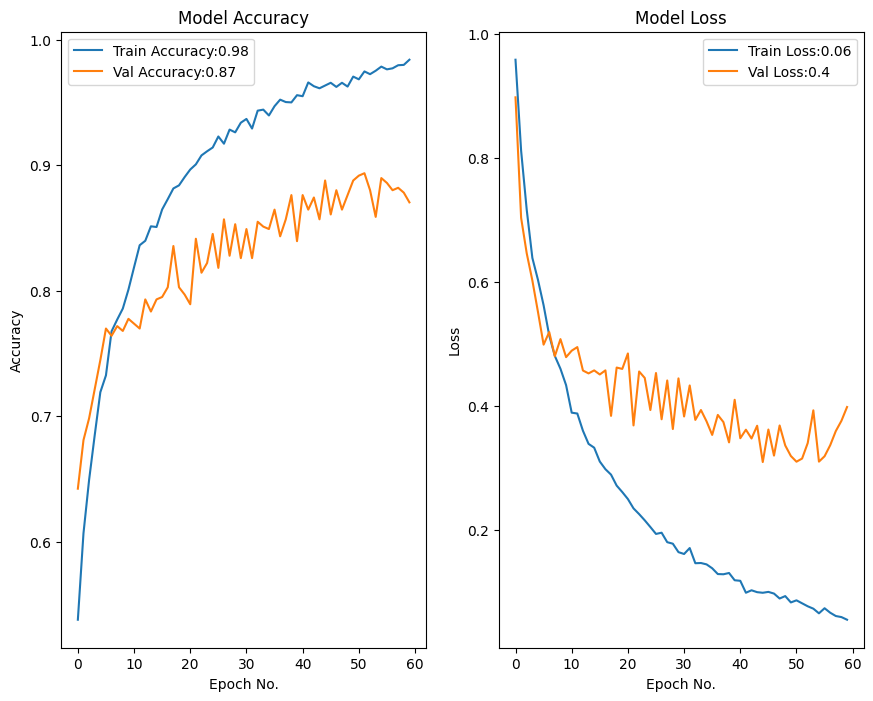

In [ ]:
import pickle,json

model_info = vgg.fit(training_set,
                    epochs=60,
                    validation_data=test_set)

vgg.save_weights('vgg_weights.h5')

history_dict = model_info.history


json.dump(history_dict, open('/content/drive/My Drive/covid_train.json', 'w'))

plot_learning_curve(history_dict)

vgg.evaluate(testing_set)

In [ ]:
vgg.save("oral.h5")

In [ ]:
loaded_model = tf.keras.models.load_model('oral.h5')

loaded_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

loaded_model.evaluate(testing_set)

30/30 [==============================] - 40s 1s/step - loss: 0.4064 - accuracy: 0.8433


[0.40638408064842224, 0.8432692289352417]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion_matrix of covid.png',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    tp = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tn = cm[1,1]
    sensitivity = (tp)/(tp+fn)
    specificity = (tn)/(tn+fp)

    print("the sensitivity",sensitivity)
    print("the specificity",specificity)

    temp1 = round(((cm[0,0])/(cm[0,0]+cm[0,1]))*100)
    temp2 = round(((cm[0,1])/(cm[0,0]+cm[0,1]))*100)
    temp3 = round(((cm[1,0])/(cm[1,0]+cm[1,1]))*100)
    temp4 = round(((cm[1,1])/(cm[1,0]+cm[1,1]))*100)

    print(temp1,temp2,temp3,temp4)
    cm[0,0] = temp1
    cm[0,1] = temp2
    cm[1,0] = temp3
    cm[1,1] = temp4
    print(cm)


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    filename = "{}.png".format(title)
    plt.savefig(filename)


# New Section

In [ ]:
model=load_model('/content/drive/My Drive/oral.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                             

In [ ]:
f = open('incresnt_metrics2.txt','w')
for m in glob.glob('/content/drive/My Drive/oral.h5'):
    f.write(m)
    f.write('\n')
    model=load_model('/content/drive/My Drive/oral.h5')
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_set = test_datagen.flow_from_directory('/content/drive/My Drive/oral/test',
    target_size = (256,256),
    batch_size = 1,
    class_mode = 'binary')
    eval_steps = test_set.n//test_set.batch_size
    print(eval_steps)
    count = 0
    true_count = 0
    false_count = 0
    for i in range(0,eval_steps):
        count = count+1
        x,y = test_set.next()
        true = (int)(round(y[0]))
        predict = (model.predict(x))
        predict = (int)(round(predict[0][0]))
        if(true==predict):
            true_count = true_count+1
        else:
            false_count = false_count+1
    result= "count ={0} , true_count={1} and false_count ={2}".format(count,true_count,false_count)
    f.write(result)
    f.write('\n')
    print(count,true_count,false_count)

Found 459 images belonging to 2 classes.
459
1/1 [==============================] - 0s 19ms/step
459 209 250


In [ ]:
dataset = np.ndarray(shape=(1, 224, 224, 3),dtype=np.float32)

#definition to test the Messidor dataset

def covid_test(model):
  true = []
  predictions = []
  for img in glob.glob('oral/*/Normal/*.*'):
    image = tf.keras.preprocessing.image.load_img(img, target_size=(224,224,3))
    image = tf.keras.preprocessing.image.img_to_array(image)
    dataset[0] = image
    pred = model.predict(dataset)
    pred = np.argmax(pred)
    predictions.append(pred)
    true.append(0)

  for img in glob.glob('oral/*/OSCC/*.*'):
    image = tf.keras.preprocessing.image.load_img(img, target_size=(224,224,3))
    image = tf.keras.preprocessing.image.img_to_array(image)
    dataset[0] = image
    pred = model.predict(dataset)
    pred = np.argmax(pred)
    predictions.append(pred)
    true.append(1)

  print(Counter(true))
  print(Counter(predictions))

  cm = confusion_matrix(true, predictions)


  plot_confusion_matrix(cm, ["Normal","OSCC"], title='Oral_Cancer')

  print(accuracy_score(true,predictions))
  print(f1_score(true, predictions, average='weighted'))
  print(recall_score(true, predictions, average='weighted'))
  print(precision_score(true, predictions, average='weighted'))



1/1 [==============================] - 0s 21ms/step
Counter({1: 737, 0: 719})
Counter({1: 884, 0: 572})
Confusion matrix, without normalization
[[563 156]
 [  9 728]]
the sensitivity 0.9842657342657343
the specificity 0.8235294117647058
78 22 1 99
[[78 22]
 [ 1 99]]
0.8866758241758241
0.8853623710116674
0.8866758241758241
0.902904010582178


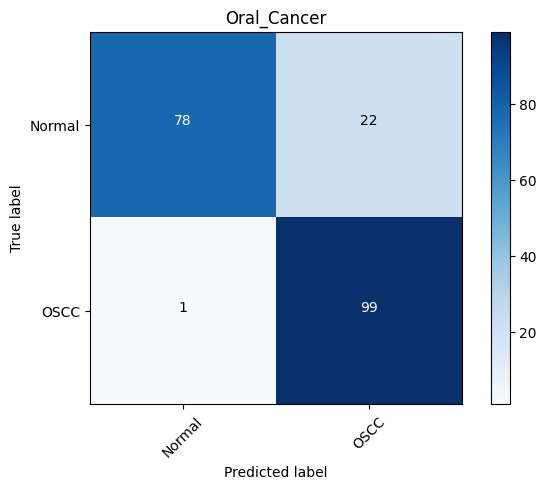

In [ ]:
covid_test(loaded_model)